In [1]:
import tensorflow as tf
import modules.tf_util as tf_util
import numpy as np
import tables
import matplotlib.pyplot as plt

#######################################################
# Get data
#######################################################
data_path = '/home/marsdenlab/datasets/DeepVesselData/'
train = data_path+'train_dist72.hdf5'
val = data_path+'val_dist72.hdf5'
test = data_path+'test_dist72.hdf5'

f_train = tables.open_file(train)
f_val = tables.open_file(val)

input_shape = f_train.root.X.shape
output_shape = f_train.root.Y.shape
print input_shape, output_shape

print 'data shapes, train={},{}'.format(input_shape,output_shape)




(44854, 72, 72, 72) (44854, 72, 72, 72, 3)
data shapes, train=(44854, 72, 72, 72),(44854, 72, 72, 72, 3)


In [2]:
######################################################
# Define variables
######################################################
N = f_train.root.X.shape[0]
Nval = f_val.root.X.shape[0]
W,H,D = f_train.root.X[0].shape
C = 1
Nbatch = 32
lr = 1e-2
Nsteps=1000
print_step=100
init = 1e-3
Nlayers = 2
#########################################################
# Define graph
#########################################################
x = tf.placeholder(shape=[None,W,H,D,C],dtype=tf.float32)
y = tf.placeholder(shape=[None,W,H,D,C],dtype=tf.float32)
#Lets make a resnet!
# o_1 = tf_util.resnet_conv3D_N(x,scope='first_conv',init=init)

# o_2 = tf_util.resnet_conv3D_N(o_1,scope='second_conv',init = init)


# o_3 = tf_util.resnet_conv3D_N(o_2,scope='third_conv',init=init)


# o_4 = tf_util.resnet_conv3D_N(o_3,scope='fourth_conv',init=init)
o_4 = tf_util.conv3D_N(x,N=Nlayers)

yhat = tf_util.conv3D(o_4,tf.identity,nfilters=1,scope='yhat',init=init)
yclass = tf.sigmoid(yhat)

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y,logits=yhat,name='loss'))

opt = tf.train.AdamOptimizer(lr)
train = opt.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

print yhat

Tensor("yhat/a:0", shape=(?, 72, 72, 72, 1), dtype=float32)


ERROR:root:Line magic function `%matplolib` not found.


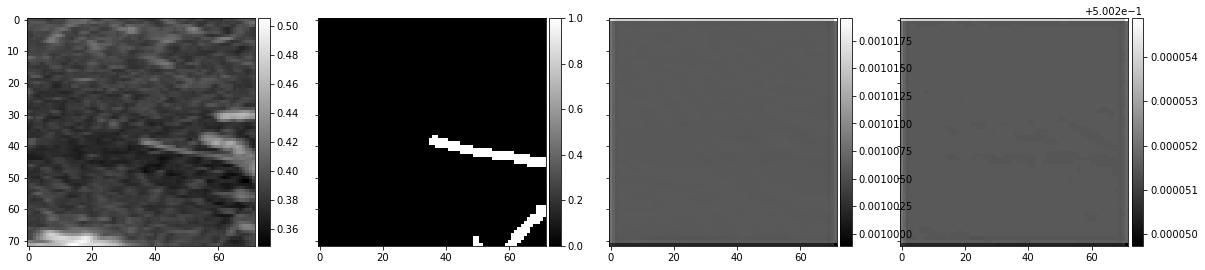

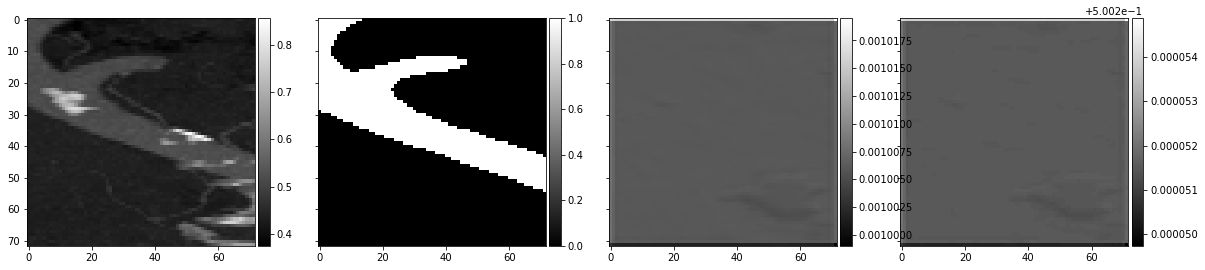

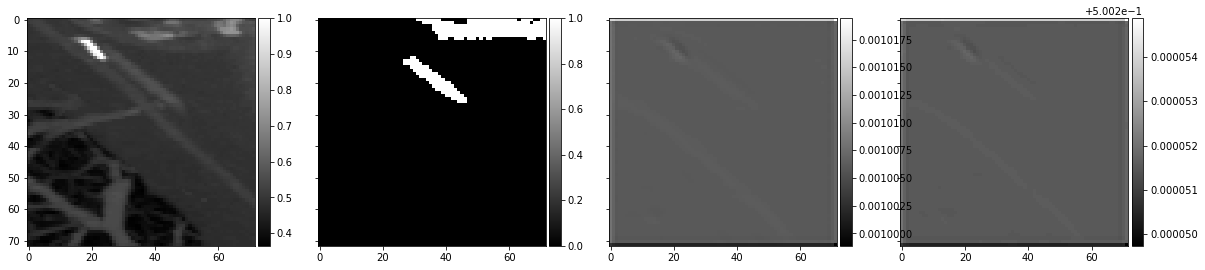

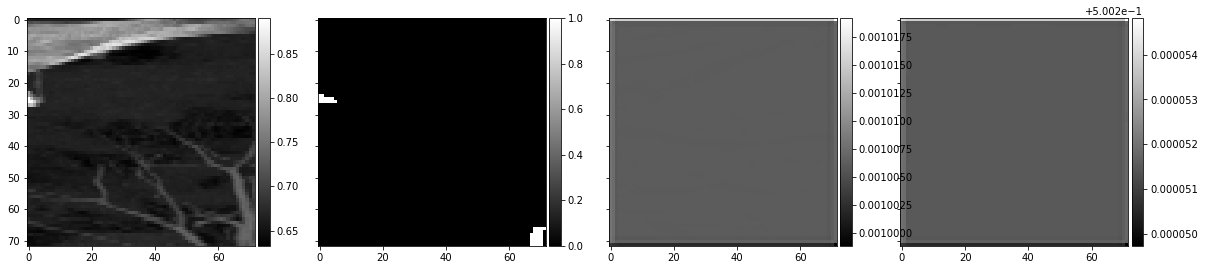

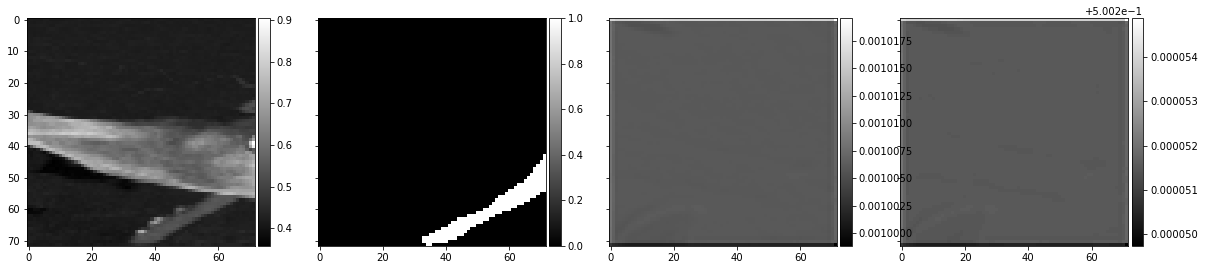

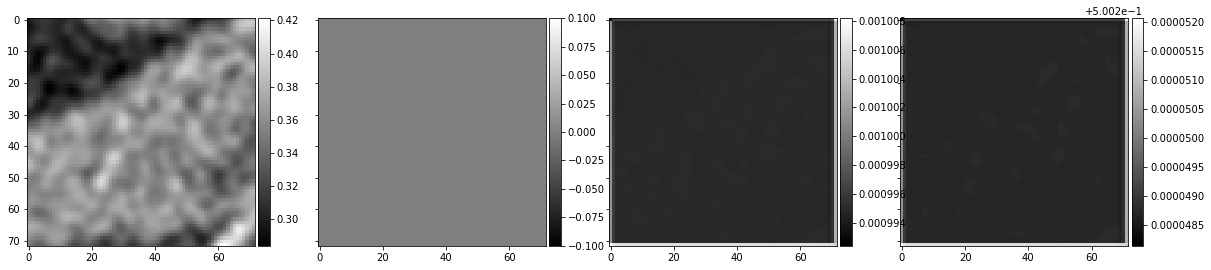

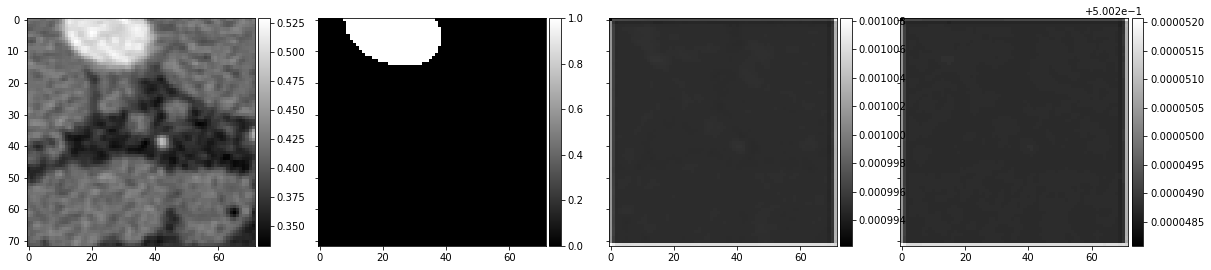

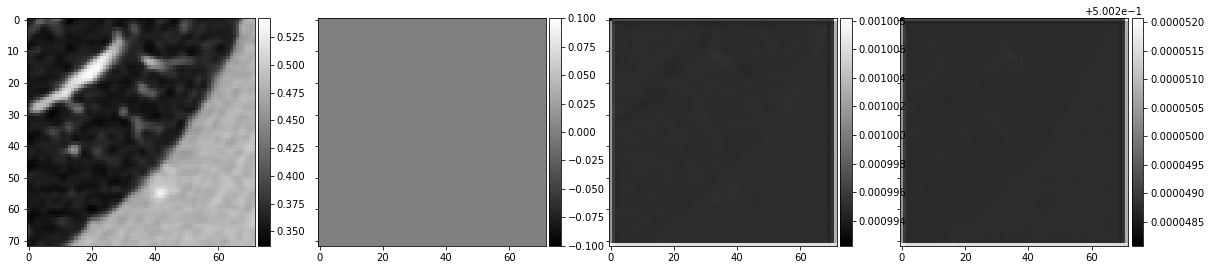

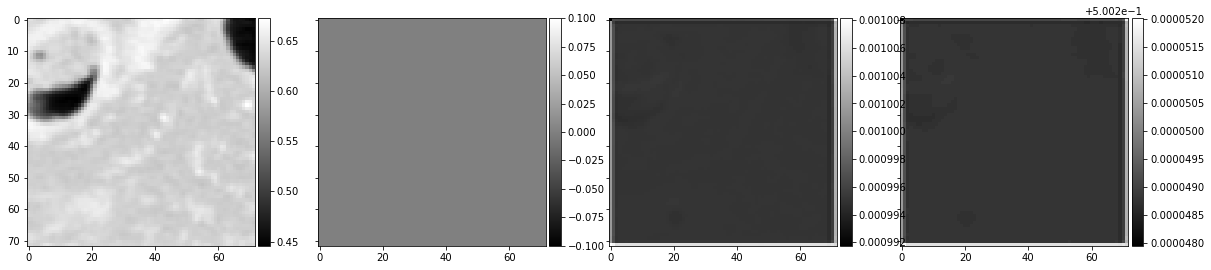

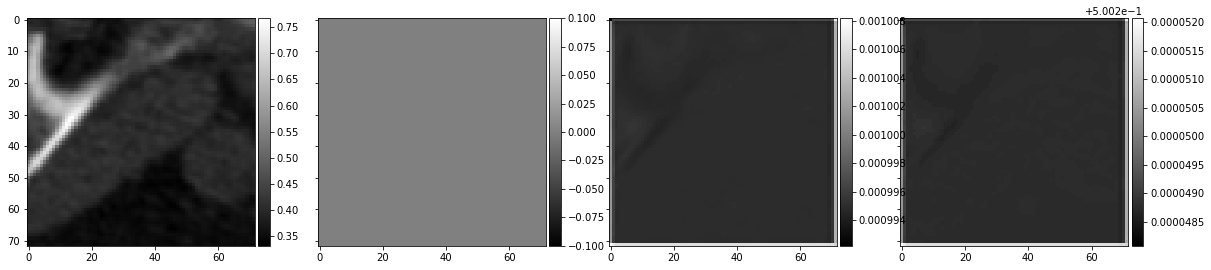

In [3]:
######################################################
# Plot
######################################################
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplolib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)
def implot(mp,ax):
    im = ax.imshow(mp.astype(np.float32), cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    
xb,yb = tf_util.get_batch(f_train.root.X,f_train.root.Y,N,n=Nbatch,y_index=0)
out,yout =sess.run([yhat,yclass],{x:xb,y:yb})

for i in range(5):
    xval = xb[i:i+2]
    yval = yb[i:i+2][:,:,:,:]
    ypred = yout[i:i+2]
    out_pred = out[i:i+2]
    mpx = np.amax(xval[0,:,:,:,0],axis=(1))
    mpy = np.amax(yval[0,:,:,:,0],axis=(1))
    mpo = np.amax(out_pred[0,:,:,:,0],axis=(1))
    mpd = np.amax(ypred[0,:,:,:,0],axis=(1))
    
    plt.figure()
    fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, sharey=True)
    implot(mpx,ax1)
    implot(mpy,ax2)
    implot(mpo,ax3)
    implot(mpd,ax4)
    plt.tight_layout
    plt.show()
    
for i in range(5):
    xval = xb[i:i+2]
    yval = yb[i:i+2][:,:,:,:]
    ypred = yout[i:i+2]
    out_pred = out[i:i+2]
    
    plt.figure()
    fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, sharey=True)
    implot(xval[0,32,:,:,0],ax1)
    implot(yval[0,32,:,:,0],ax2)
    implot(out_pred[0,32,:,:,0],ax3)
    implot(ypred[0,32,:,:,0],ax4)
    plt.tight_layout
    plt.show()

In [4]:
print xval.shape
print yval.shape
print out.shape
print yout.shape

(2, 72, 72, 72, 1)
(2, 72, 72, 72, 1)
(32, 72, 72, 72, 1)
(32, 72, 72, 72, 1)


In [ ]:
#######################################################
# Train
#######################################################
train_hist = []
val_hist = []

for i in range(Nsteps):
    xb,yb = tf_util.get_batch(f_train.root.X,f_train.root.Y,N,n=Nbatch,y_index=0)
    l,_=sess.run([loss,train],{x:xb,y:yb})
    if i%(print_step/5)==0:
        print "iteration {}".format(i)
    if i%print_step == 0:
        xb,yb = tf_util.get_batch(f_val.root.X,f_val.root.Y,Nval,Nbatch,y_index=0)
        lval=sess.run(loss,{x:xb,y:yb})
        print "Train: {}, Val: {}".format(l,lval)



iteration 0
Train: 0.0839373022318, Val: 0.245495140553
iteration 20
iteration 40
iteration 60
iteration 80
iteration 100
Train: 0.225351125002, Val: 0.134740009904
iteration 120
iteration 140
iteration 160
iteration 180
iteration 200
Train: 0.128466814756, Val: 0.155483588576


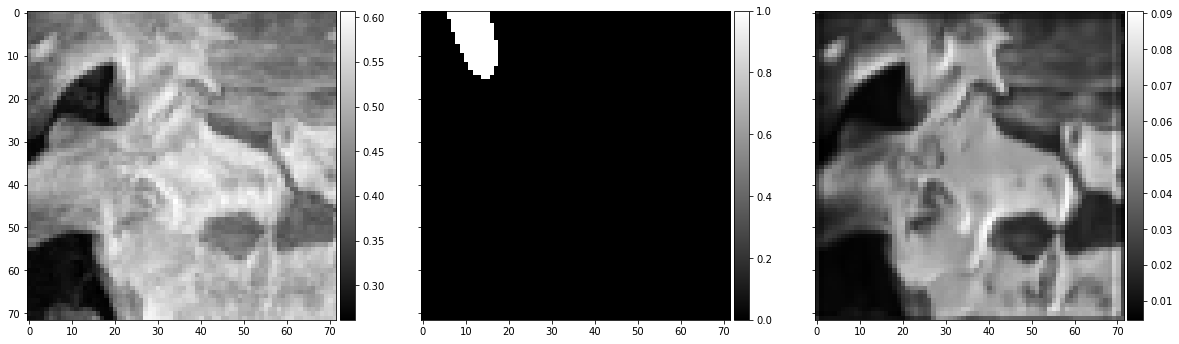

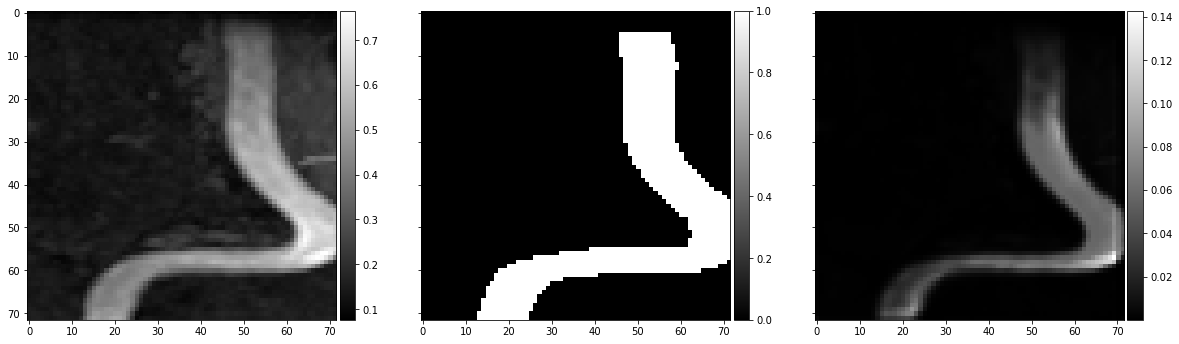

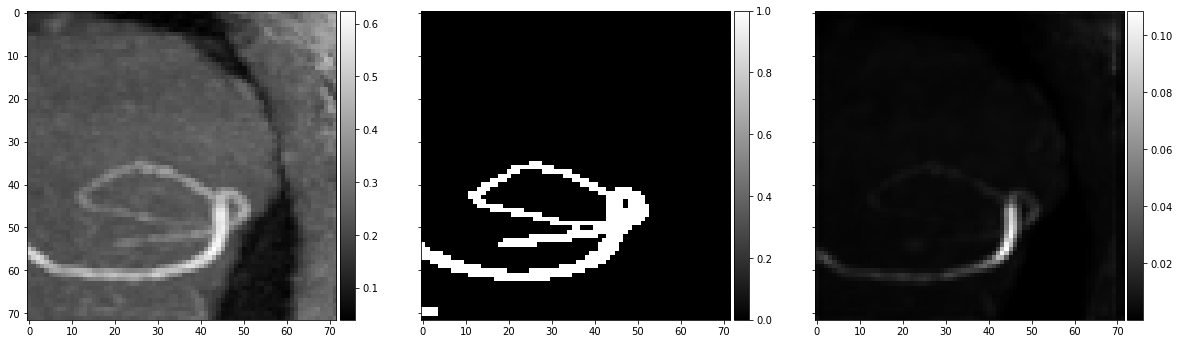

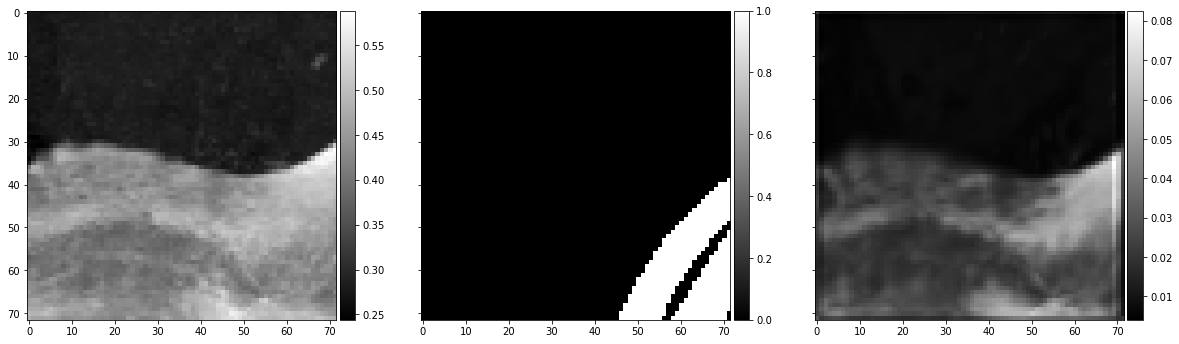

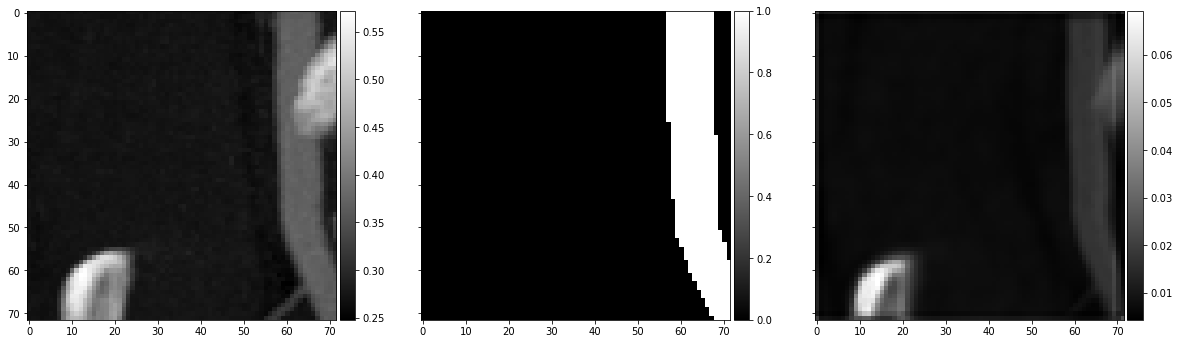

In [6]:


for i in range(5):
    j = np.random.randint(len(f_val.root.X))
    xval = f_val.root.X[j:j+2][:,:,:,:,np.newaxis]
    yval = f_val.root.Y[j:j+2][:,:,:,:,0]
    yval = yval[:,:,:,:,np.newaxis]
    ypred = sess.run(yclass,{x:xval,y:yval})
    mpx = np.amax(xval[0,:,:,:,0],axis=(1))
    mpy = np.amax(yval[0,:,:,:,0],axis=(1))
    mpd = np.amax(ypred[0,:,:,:,0],axis=(1))

    plt.figure()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    implot(mpx,ax1)
    implot(mpy,ax2)
    implot(mpd,ax3)
    plt.tight_layout
    plt.show()